# Generate artificial faces with GANs

In this difficult but very guided exercise, you will learn to train a generative adversarial network in order to generate faces. You will come to realize that the more complex the base distribution you are trying to simulate the more difficult it will become to train the model.

## Load data

1. Import tensorflow

In [3]:
import tensorflow as tf

2. Use the `tf.keras.utils.get_file` function in order to load the data from this link `https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/gans/img_align_celeba.zip`, set the `untar` argument to false as the archive format here is not supported by the function, we will unzip it separately.

In [5]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/gans/img_align_celeba.zip',
                                         fname=r"C:\Users\Berenger\Documents\GitHub\Jedha_Bootcamp\M07-Deep_Learning\D06-Gans\gans\img_align_celeba.zip", 
                                         untar=False,
                                         cache_subdir="")

1443504128/1443490838 [==============================] - 50s 0us/step


3. Use the `!unzip` command in order to unzip the .zip file you just downloaded

In [10]:
!tar -xf C:\Users\Berenger\Documents\GitHub\Jedha_Bootcamp\M07-Deep_Learning\D06-Gans\gans\img_align_celeba.zip

4. Use the `!mkdir` command in order to create a folder called `img` inside the `content` directory.

In [11]:
!mkdir C:\Users\Berenger\Documents\GitHub\Jedha_Bootcamp\M07-Deep_Learning\D06-Gans\img

5. Use `!mv` to move the unziped folder to the img folder

In [13]:
!move C:\Users\Berenger\Documents\GitHub\Jedha_Bootcamp\M07-Deep_Learning\D06-Gans\img_align_celeba C:\Users\Berenger\Documents\GitHub\Jedha_Bootcamp\M07-Deep_Learning\D06-Gans\img

        1 dir(s) moved.


## Data Preprocessing

1. Create an instance of `ImageDataGenerator` with no transformation other than a rescaling. (Make sure you rescale the images so that the values of the pixel range from 0 to 1)

In [68]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False,
                                                                vertical_flip=False,
                                                                rescale=1/255)

2. Set a variable named `BATCH_SIZE` to 64 and create an `img_generator_flow` object using the `.flow_from_directory` method. The traget size we are working with here is 64 by 64.

In [70]:
BATCH_SIZE = 64

img_generator_flow = img_generator.flow_from_directory(
    directory=r"C:\Users\Berenger\Documents\GitHub\Jedha_Bootcamp\M07-Deep_Learning\D06-Gans\img",
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True)
    

Found 202599 images belonging to 1 classes.


3. Now that we are ready to generate images, display one batch of images from the flow.

Label : img_align_celeba


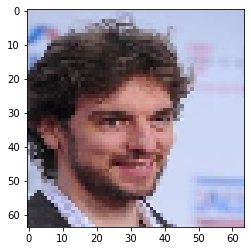

Label : img_align_celeba


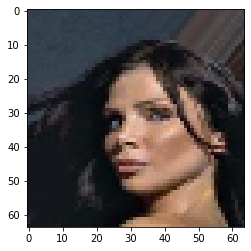

Label : img_align_celeba


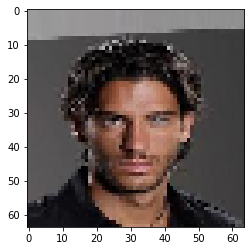

Label : img_align_celeba


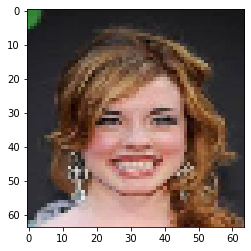

Label : img_align_celeba


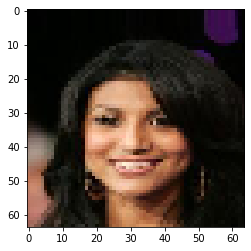

Label : img_align_celeba


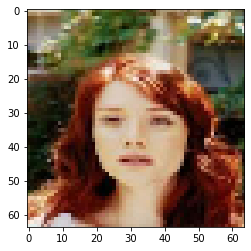

Label : img_align_celeba


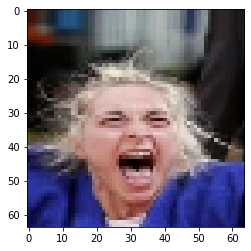

Label : img_align_celeba


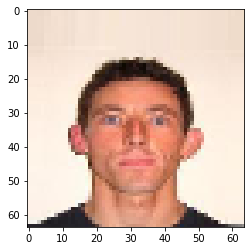

Label : img_align_celeba


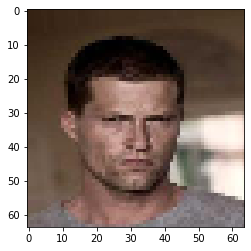

Label : img_align_celeba


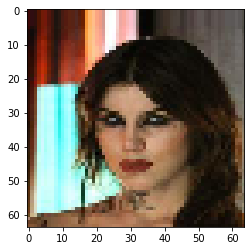

Label : img_align_celeba


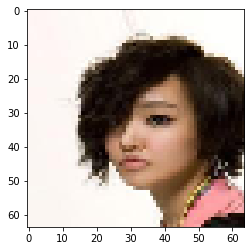

Label : img_align_celeba


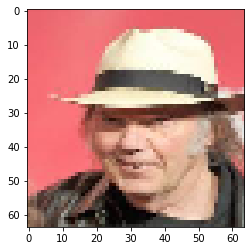

Label : img_align_celeba


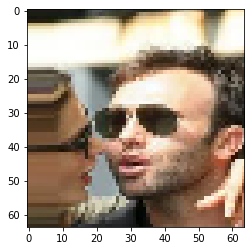

Label : img_align_celeba


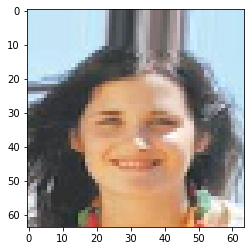

Label : img_align_celeba


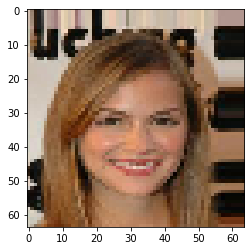

Label : img_align_celeba


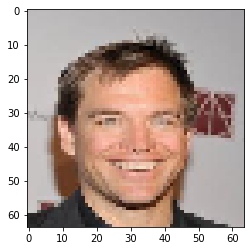

Label : img_align_celeba


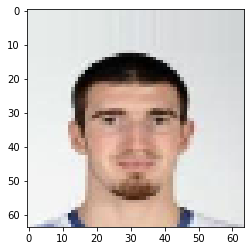

Label : img_align_celeba


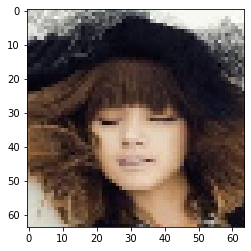

Label : img_align_celeba


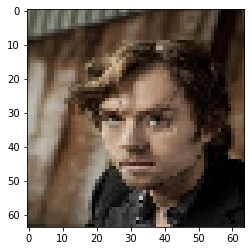

Label : img_align_celeba


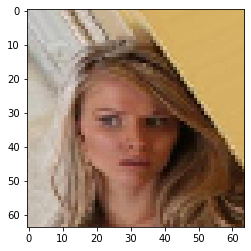

Label : img_align_celeba


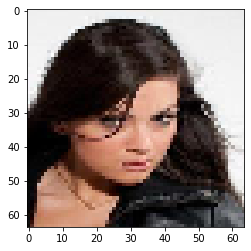

Label : img_align_celeba


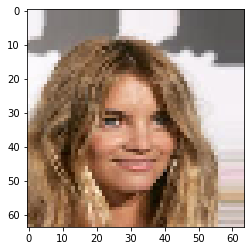

Label : img_align_celeba


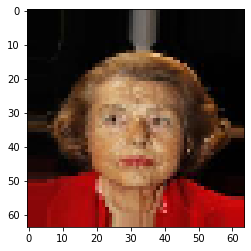

Label : img_align_celeba


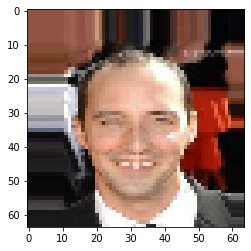

Label : img_align_celeba


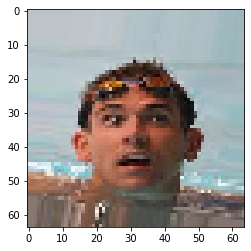

Label : img_align_celeba


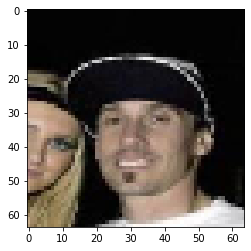

Label : img_align_celeba


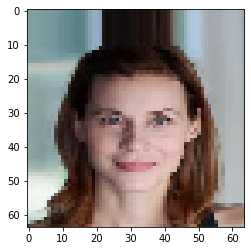

Label : img_align_celeba


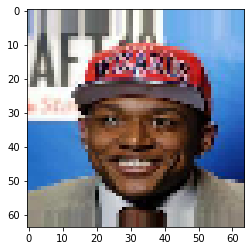

Label : img_align_celeba


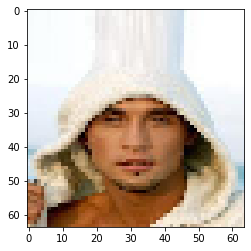

Label : img_align_celeba


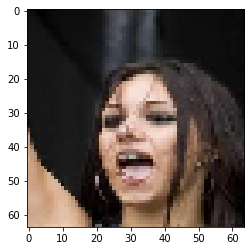

Label : img_align_celeba


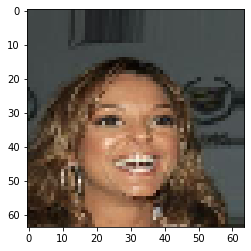

Label : img_align_celeba


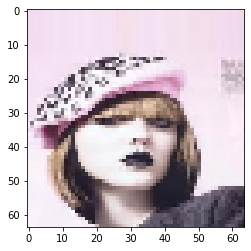

Label : img_align_celeba


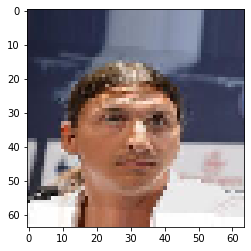

Label : img_align_celeba


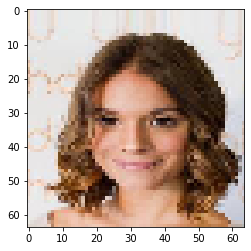

Label : img_align_celeba


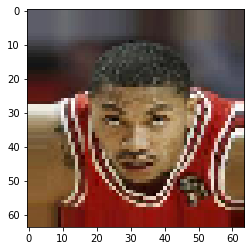

Label : img_align_celeba


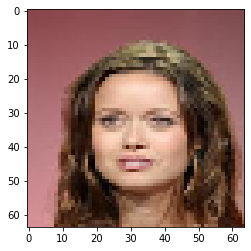

Label : img_align_celeba


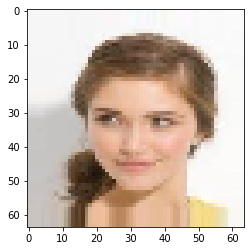

Label : img_align_celeba


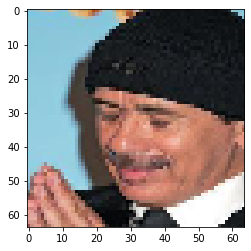

Label : img_align_celeba


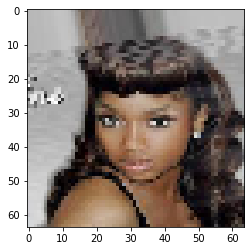

Label : img_align_celeba


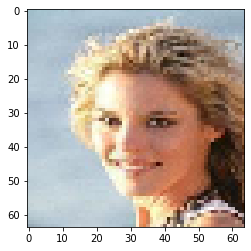

Label : img_align_celeba


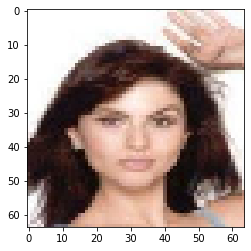

Label : img_align_celeba


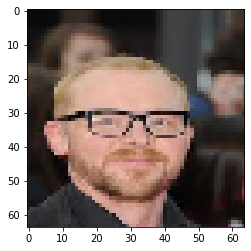

Label : img_align_celeba


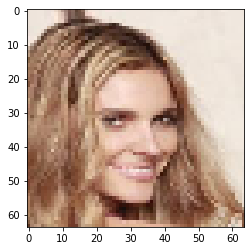

Label : img_align_celeba


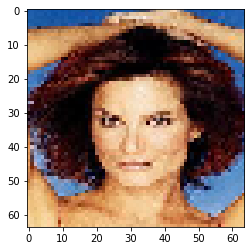

Label : img_align_celeba


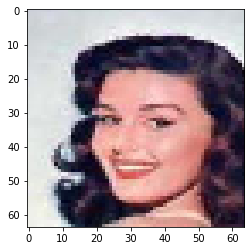

Label : img_align_celeba


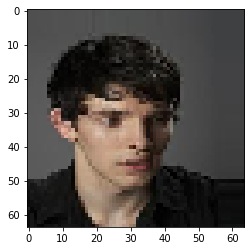

Label : img_align_celeba


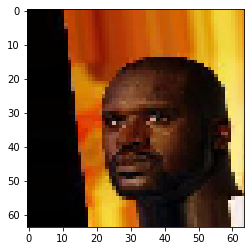

Label : img_align_celeba


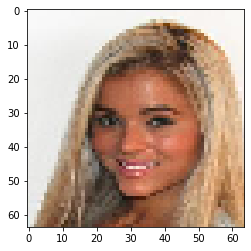

Label : img_align_celeba


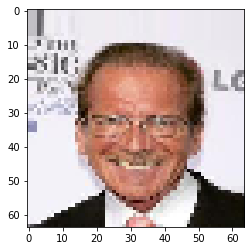

Label : img_align_celeba


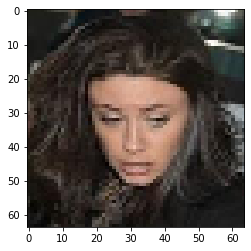

Label : img_align_celeba


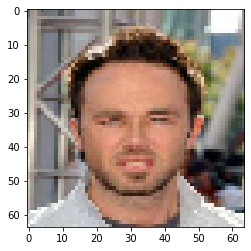

Label : img_align_celeba


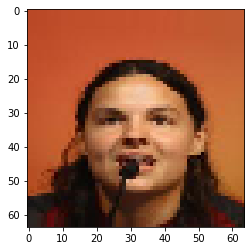

Label : img_align_celeba


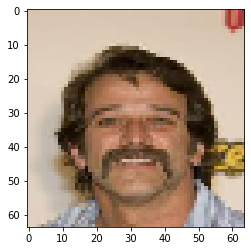

Label : img_align_celeba


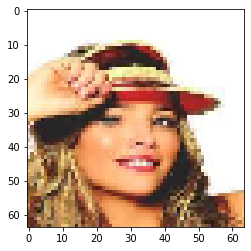

Label : img_align_celeba


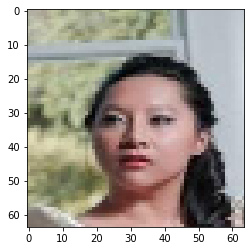

Label : img_align_celeba


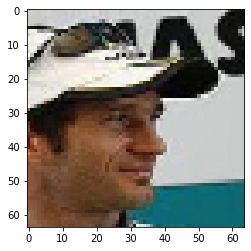

Label : img_align_celeba


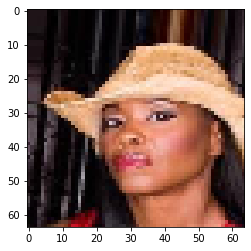

Label : img_align_celeba


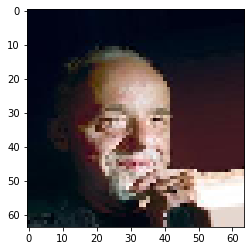

Label : img_align_celeba


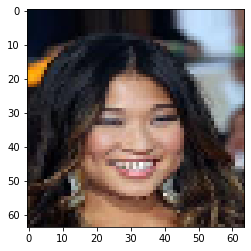

Label : img_align_celeba


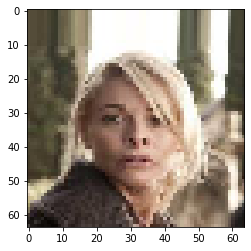

Label : img_align_celeba


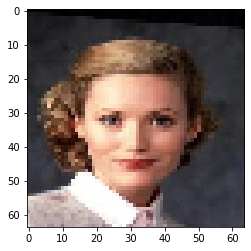

Label : img_align_celeba


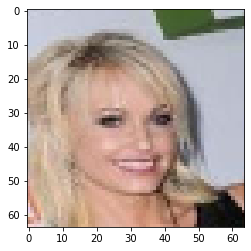

Label : img_align_celeba


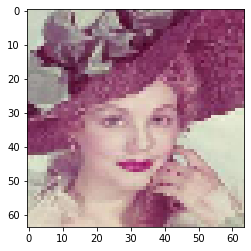

Label : img_align_celeba


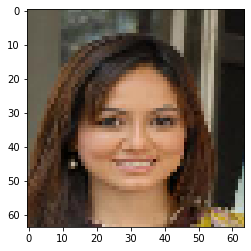

In [71]:
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path

imgs, labels = next(iter(img_generator_flow))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow.labels == tf.argmax(label))
  true_label_name = Path(img_generator_flow.filepaths[true_file_path]).parent.name
  print("Label :", true_label_name)
  plt.imshow(img)
  plt.show()

## Generator Model

1. Now it is time to create the generator model which will take some noise vector and transform it into an output the same size as our pictures. First set up a variable `LATENT_DIM` equal to 100 (this is the dimension of the noise vectors we will convert to images). Set a variable `CHANNELS` equal to 3.

In [72]:
LATENT_DIM = 100
CHANNELS = 3

2. Create a sequential model called generator with the following architecture:

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/generator.png" />

For this model we got our inspiration from the following [paper](https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/GAN.pdf) which suggests that:

* All Conv Transpose layers use `padding="same"`, `kernel_size=5`, `strides=2` and `activation="relu"`, except for the last layer which needs to have a `"sigmoid"` activation (because the generator model needs to produce pixels with values between 0 and 1).

In [73]:
from tensorflow.keras.layers import *
generator = tf.keras.Sequential([
                                 Dense(4*4*512, activation="relu", input_shape=[LATENT_DIM]),
                                 Reshape([4,4,512]),
                                 Conv2DTranspose(256, kernel_size=5, strides=2, padding="same", activation="relu", use_bias=False),
                                 BatchNormalization(),
                                 Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu", use_bias=False),
                                 BatchNormalization(),
                                 Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu", use_bias=False),
                                 BatchNormalization(),
                                 Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="sigmoid")
                                 ])

In [74]:
generator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 8192)              827392    
                                                                 
 reshape_23 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 8, 8, 256)        3276800   
 Transpose)                                                      
                                                                 
 batch_normalization_56 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 16, 16, 128)      819200    
 Transpose)                                                      
                                                     

3. Create a random noise vector and feed it to the generator model in order to try it out. (Use `tf.random.normal` to generate the data and do not hesitate to multiply it by 100 to make some variations appear on the output image)

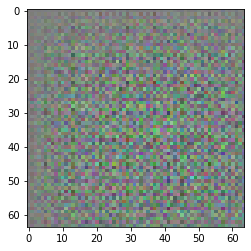

In [75]:
### Random pixel size creation (1, 100)
random_pixels = tf.random.normal([1,LATENT_DIM])*100

### Model application
rand_img = generator.predict(random_pixels)

### Model visualisation
plt.imshow(tf.squeeze(rand_img))

## Discriminator Model

1. Create a sequential model called `discriminator` with the following architecture :

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/discriminator.png" />

* All layers use `padding="same"`, `kernel_size=3`, and `activation="relu"`, except for the last layer which uses `activation="sigmoid"` because the target variable is binary (the image is fake or real).

In [76]:
discriminator = tf.keras.Sequential([
    Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=imgs.shape[1:]),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(512, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
]
)

In [77]:
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_59 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_60 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                     

## Preparing for training
1. In order to train our models, we are going to use the `BinaryCrossentropy` s a base to create custom loss functions, start by creating an instance of this loss function.

In [78]:
bce = tf.keras.losses.BinaryCrossentropy()
bce

2. Define a function called `discriminator_loss` it will serve as theloss for the (you guessed it...) Discriminator model!
The goal of the discriminator is to predict `1` for real images and `0` for fake images, so we may be simply want to compute the binary cross entropy between `real_ouput` and `1`, and `fake_output` and `0`, but GANs are very sensitive models, and specifically we do not want the discriminator to get too good too quickly otherwise the generator will not be able to improve, so we will add some noise to the expected labels for the real and fake images (the idea is that we want the discriminator to think the real images are real but not 100% real, and the fake images not 100% fake, this small confusion will create some weakness that the generator will be able to exploit).

* This function will take two arguments `real_output` which are the outputs the discriminators forms from the real images and `fake_output` which the discriminator will create when applied to fake images.
* Create an object `real_label` using `tf.ones_like` on the argument `real_outputs`, and subtract some small random number, this will create the "not so real" labels we need to compare the discriminator's predictions to.
* Create an object `fake_label` using `tf.zeros_like` on the argument `fake_outputs`, and add a small random number, this will create the "not so fake" labels we need to to compare the discriminator's predictions to.
* Compute the binary cross entropy between `fake_labels` and `fake_outputs` and between `real_labels` and `real_outputs` and call them `fake_loss` and `real_loss` respectively.
* Return the sum of those two losses.

In [79]:

def discriminator_loss(real_outputs, fake_outputs):
  real_label = tf.ones_like(real_outputs) - .05 *  tf.random.uniform(real_outputs.shape)
  real_loss = bce(real_label, real_outputs) # for real data disc is expected to predict 1
  fake_label = tf.zeros_like(fake_outputs) + .05 *  tf.random.uniform(fake_outputs.shape)
  fake_loss = bce(fake_label, fake_outputs) # for fake data disc is expected to predict 0
  
  total_loss = real_loss + fake_loss # the disc loss is the sum of those two losses
  # ability to catch the fake + ability to clear the real data
  return total_loss

3. Define a function called `generator_loss` that takes `fake_outputs` as an argument and computes the binary cross entropy between a vector of ones and the `fake_outputs`. We want the generator to fool the discriminator as much as possible!

In [80]:
def generator_loss(fake_outputs):
  return bce(tf.ones_like(fake_outputs), fake_outputs) # gen wants disc to think fake data is real (predicted as 1)

4. Create two objects `generator_optimizer` and `discriminator_optimizer` that are aqual to `Adam` optimizers, as is recommended in the paper.

In [81]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

## Training Step

In this question we will guide you step by step to create your training step function, it is directly inspired from the demo on the MNIST dataset so do not hesitate to find help there as well!

Define a `train_step` function taking one argument called `images` this will represent a batch of real images.
* create two variables `noise` and `noise2` that are random vectors taken from a normal distribution with shape `[BATCH_SIZE,LATENT_DIM]`
* Use `tf.GradientTape()` twice to tape the gradient of the dscriminator and the generator respectively, which you will alias `gen_tape` and `disc_tape`.
  * Apply the generator to the two noise vectors to generate two sets of artificial images.
  * Turn the two sets of artificial images into two sets of fake outputs thanks to the discriminator model.
  * Use the discriminator model to transform the `images` argument into a real output.
  * Using the real output and the first set of fake output compute the discriminator loss
  * Using the second set of fake output compute the generator loss
  * Use both tapes to calculate the gradients for both models
  * Use both optimizers in order to update the two models' parameters
* Return the generator loss and the discriminator loss


In [82]:
def train_step(images): # the function takes a batch of images as argument
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM]) # generate a batch of noise
    noise2 = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    # The GradientTape class is able to monitor and record the gradient of a given
    # tensorflow function, we will use it here to calculate the gradients of our
    # loss functions
    # We will need a tape for each of the models
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # generate a batch of fake data
      generated_images2 = generator(noise2, training=True) # generate a batch of fake data

      # the training=True argument is for the batch normalization

      real_output = discriminator(images, training=True) # compute the real outputs from the real data
      fake_output = discriminator(generated_images, training=True) # compute the fake outputs from the fake data
      fake_output2 = discriminator(generated_images2, training=True) # compute the fake outputs from the fake data

      gen_loss = generator_loss(fake_output2) # compute the generator loss
      disc_loss = discriminator_loss(real_output, fake_output) # compute the discriminator loss

      # the tf.GradientTape() .gradient(value, variables) method will calculate the gradient 
      # of a given function at point "value" according to "variables", note that this
      # works because we built everything with tensorflow functions
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # the tf.keras.optimizer .apply_gradients(zip(grad,variables)) method updates the 
      # variables by running variables = variables - learning_rate * grad
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    real_pred = real_output.numpy()>0.5
    fake_pred = fake_output.numpy()>0.5
    return real_pred, fake_pred, gen_loss, disc_loss

## Utility function

This function will help you visualize the generated data throughout the training process.

In [83]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # Remove the previous image 
  display.clear_output(wait=True)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

We will also create a `seed` object that is a set of random noise which will never change during training and will help us control the generator's performance evolutions.

In [84]:
# Generate the fixed generated examples
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])

## Training Loop

Loop over 1000 epochs with 5 steps per epochs (each epoch should take between 10 and 20 seconds using GPU). At each step use the train step function, print out the discriminator loss and the generator loss. At the end of each epoch use the utility function defined above in order to display the images generated from the `seed` object.

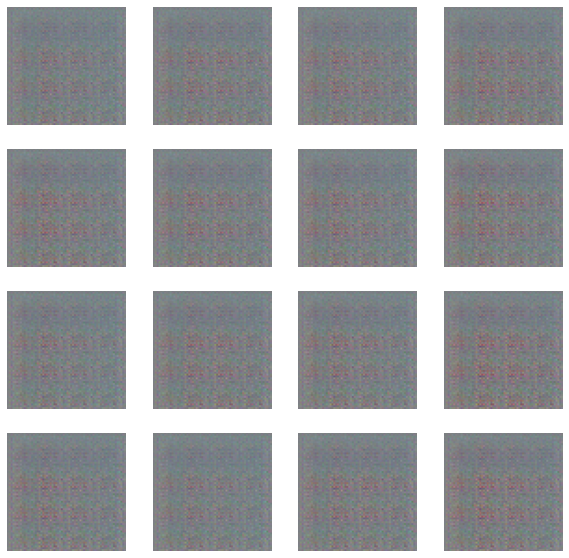

Time for epoch 4 is 29.05421733856201 sec


KeyboardInterrupt: 

In [85]:
EPOCHS = 100000
steps_per_epochs=5
from IPython import display
import time
# loop over the number of epochs that we want to run
for epoch in range(EPOCHS):
  start = time.time()
  real_score = 0
  real_len = 0
  fake_score = 0
  fake_len = 0
  # loop over each batch in the source dataset
  for i in range(steps_per_epochs):
    image_batch,_ = next(iter(img_generator_flow))
    # Run a training step to update the parameters in both models
    real_pred, fake_pred, gen_loss, disc_loss = train_step(image_batch)
    real_score += real_pred.sum()
    fake_score += fake_pred.sum()
    real_len += real_pred.shape[0]
    fake_len += fake_pred.shape[0]

  # Print generator score vs disc score
  print("real pred", real_score/real_len)
  print("\n fake pred", fake_score/fake_len)
  print("disc loss", disc_loss)
  print("\n gen pred", gen_loss)
  # Displays the new generated image
  generate_and_save_images(generator,
                           epoch + 1,
                           seed)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Génère la toute dernière image
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)

Here is what you can hope to see after 1000 epochs (or 5000 steps):

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/gans/generated_99.png" />

GANs are hard to train and are very ressource-intensive models to train, and the difficulty increases exponentially with the dimension of the distribution you are trying to model (for instance training a model that could generate super realistic images in HD took 3 months for Google to train!)